In [1]:
!pip install torchsummary jupyter-autotime
!pip install --upgrade tqdm 
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image
import torchsummary
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import torch
from tqdm.auto import tqdm
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.8/793.8 kB 24.5 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 8.14.0
    Uninstalling ipython-8.14.0:
      Successfully uninstalled ipython-8.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyterlab<5.0.0a0,>=4.0.6, but you have jupyterlab 4.0.5 which is incompatible.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class cfg:
    images_path = "/kaggle/input/15-of-120-dogs-dataset/120-dog-breeds-breed-classification/Images"
    

# Dog Breed Classification
Dataset link: [kaggle/datasets/amandam1/120-dog-breeds-breed-classification](https://www.kaggle.com/datasets/amandam1/120-dog-breeds-breed-classification)

We are selecting 15 out of 120 categories due to the insufficient amount of data, as well as the lack of sufficient quality in the photos within the dataset. Here's the list dog breeds that'll used in this project:


| #    | Dog Breed            |
|------|----------------------|
| 1    | Afghan Hound         |
| 2    | Basset               |
| 3    | Bernese Mountain dog |
| 4    | Bloodhound           |
| 5    | Chiuahua             |
| 6    | French Bulldog       |
| 7    | Great Dane           | 
| 8    | Irish Wolfhound      |
| 9    | Italian Greyhound    |
| 10   | Komondor             |
| 11   | Mexican Hairless     |
| 12   | Rottweiler           |
| 13   | Shih Tzu             |
| 14   | Siberian Husky       |
| 15   | Standard Poodle      |


In [3]:
# saving the image paths into a dict

path_dict = {}

for root, folder_names, files in os.walk(cfg.images_path, topdown=False):
    breed_name = root.split("/")[-1].split("-")[-1]
    image_paths = [os.path.join(root, i) for i in files]
    path_dict[breed_name] = image_paths
       

In [4]:
def process_image(image_path, size):
    # Read the image and convert to rgb
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width = img.shape[:2]
    
    # checking if image is portrait or lancscape
    if height > width:
        # Calculate the padding needed to make the image square
        padding = (height - width) // 2
        # Add equal padding to the left and right sides of the image
        img_padded = cv2.copyMakeBorder(img, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    else:
        padding = (width - height) // 2
        img_padded = cv2.copyMakeBorder(img, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Resize the image to the specified size using cubic interpolation
    img_resized = cv2.resize(img_padded, size, interpolation=cv2.INTER_CUBIC)
    return img_resized

# Data Preprocessing

In [5]:
# This code was originally written for speeding up the preprocessing of ~10k photos

def save_image(path, save_path, size):
    # Process the image
    img = process_image(path, size)

    img_pil = Image.fromarray(img)
    img_pil.save(save_path)

base_train_dir = os.path.join("/kaggle/working",'dataset/train')
base_val_dir = os.path.join("/kaggle/working",'dataset/val')
IMAGE_SIZE = (400, 400)

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = []
    for breed, image_paths in path_dict.items():
        # Create folders for train and val for each breed
        train_breed_dir = os.path.join(base_train_dir, breed)
        val_breed_dir = os.path.join(base_val_dir, breed)
        os.makedirs(train_breed_dir, exist_ok=True)
        os.makedirs(val_breed_dir, exist_ok=True)

        # Split the image paths into train and validation sets 90% train - 10% val
        if len(image_paths) ==0:
            continue
        
        train_paths, val_paths = train_test_split(image_paths, test_size=0.1)

        # Schedule saving train images
        for path in train_paths:
            save_path = os.path.join(train_breed_dir, os.path.basename(path))
            futures.append(executor.submit(save_image, path, save_path, IMAGE_SIZE))

        # Schedule saving validation images
        for path in val_paths:
            save_path = os.path.join(val_breed_dir, os.path.basename(path))
            futures.append(executor.submit(save_image, path, save_path, IMAGE_SIZE))

    # Wait for all tasks to complete
    for future in as_completed(futures):
        future.result()

print("Images have been successfully split and saved into train and val folders.")

Images have been successfully split and saved into train and val folders.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile


## Transforming
now we have the dataset file system in this shape. We'll normalize the images with ImageNet mean and std values and load the images into pytorch dataloaders.

```
cfg.images_path/dataset
├── train
│   ├── dog_breed1
│   │   └── images
│   ├── dog_breed2
│   │   └── images
│   └── ...
└── val
    ├── dog_breed1
    │   └── images
    ├── dog_breed2
    │   └── images
    └── ...

```


In [7]:
# adding random rotation, flip in training set. We don't need to resize it here since we already preprocessed them with IMAGE_SIZE
img_transform = {
    'valid':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) # imagenet mean and std values
    ]),
    'train':transforms.Compose([
        transforms.RandomRotation(degrees = 3),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ])
}



In [8]:
train_path = "/kaggle/working/dataset/train"
val_path = "/kaggle/working/dataset/val"

In [9]:
!rm -rf /kaggle/working/dataset/val/Images
!rm -rf /kaggle/working/dataset/train/Images

In [10]:
train_data = datasets.ImageFolder(root=train_path, transform=img_transform['train'])
val_data = datasets.ImageFolder(root=val_path, transform=img_transform['valid'])

BATCH_SIZE = 200

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
num_output_classes = len(os.listdir(train_path))
print(num_output_classes)

15


In [12]:
import torch.nn.init as init
class DogeCNN(nn.Module):
    def __init__(self):
        super(DogeCNN, self).__init__()

        # Conv layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32, kernel_size=3, padding=1, stride=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 12 * 12, 32 * 12 * 12)
        self.fc2 = nn.Linear(32 * 12 * 12, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, num_output_classes)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # applying conv layers, batch normalizations, activation function and pooling
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        #x = self.pool(F.relu(self.batchnorm5(self.conv5(x))))
        #print(x.shape)
        # Flatten the output for fully connected layers
        x = x.view(-1, 128 * 12 * 12)

        # Apply fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = (self.fc4(x))

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # initializing weights with kaiming initialization
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
dogeCNN = DogeCNN().to(device)
dogeCNN._initialize_weights()

In [15]:
from torchsummary import summary
summary(dogeCNN, input_size=tuple([3])+IMAGE_SIZE) # 3 channels for RGB and image size which is 400x400

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 400, 400]             448
       BatchNorm2d-2         [-1, 16, 400, 400]              32
         MaxPool2d-3         [-1, 16, 200, 200]               0
            Conv2d-4         [-1, 32, 200, 200]           4,640
       BatchNorm2d-5         [-1, 32, 200, 200]              64
         MaxPool2d-6         [-1, 32, 100, 100]               0
            Conv2d-7         [-1, 64, 100, 100]          18,496
       BatchNorm2d-8         [-1, 64, 100, 100]             128
         MaxPool2d-9           [-1, 64, 50, 50]               0
           Conv2d-10          [-1, 128, 25, 25]          73,856
      BatchNorm2d-11          [-1, 128, 25, 25]             256
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Linear-13                 [-1, 4608]      84,939,264
          Dropout-14                 [-

In [24]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

def train_model_with_validation(model, train_loader, validation_loader, epochs, model_name, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    time.sleep(0.1)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    model = model.to(device)

    with open(f"{model_name}_results.txt", "w") as f:
        for epoch in (pbar := tqdm(range(epochs))):
            # Training
            pbar.set_description("Training...")
            model.train()
            train_losses = []
            total = 0
            correct = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            avg_train_loss = sum(train_losses) / len(train_losses)
            train_accuracy = 100 * correct / total

            # Validation
            model.eval()
            validation_losses = []
            total = 0
            correct = 0
            with torch.no_grad():
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    validation_losses.append(loss.item())

                    # Calculate accuracy
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            avg_val_loss = sum(validation_losses) / len(validation_losses)
            val_accuracy = 100 * correct / total

            # Print & save results to file
            results = (f"Epoch [{epoch+1}/{epochs}], "
                       f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
                       f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
            print(results)
            f.write(results + "\n")

            # Save checkpoints every 5 epochs
            if (epoch + 1) % 5 == 0:
                save_checkpoint(model, optimizer, epoch, criterion, filename=f'{model_name}_checkpoint_{epoch+1}.tar')

    return train_losses, validation_losses, epoch
    
    
def plot_losses(train_losses, validation_losses, epoch):
    epochs_list = list(range(1, len(train_losses))) # 

    plt.figure(figsize=(12, 6))
    plt.plot(epochs_list, train_losses, label='Training Loss')
    plt.plot(epochs_list, validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [17]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            # Assuming you're using a GPU, if available
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Plotting confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    return accuracy, f1, precision, recall

In [18]:
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.tar'):
    """
    Save model, optimizer, epoch, and loss into a file so that training can be resumed later.
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)

def load_checkpoint(model, optimizer, filename='checkpoint.tar'):
    """
    Load model, optimizer, epoch, and loss from a file.
    Call this function before resuming training or for inference.
    """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return model, optimizer, epoch, loss


In [19]:
doge_train_losses, doge_validation_losses, doge_epoch = train_model_with_validation(dogeCNN, train_loader, val_loader, 30, "dogeCNN", device)

Training...:   3%|▎         | 1/30 [00:23<11:30, 23.80s/it]

Epoch [1/30], Train Loss: 2.9213, Train Accuracy: 7.60%, Validation Loss: 2.7086, Validation Accuracy: 7.56%


Training...:   7%|▋         | 2/30 [00:46<10:43, 23.00s/it]

Epoch [2/30], Train Loss: 2.7068, Train Accuracy: 7.78%, Validation Loss: 2.6913, Validation Accuracy: 10.49%


Training...:  10%|█         | 3/30 [01:08<10:17, 22.88s/it]

Epoch [3/30], Train Loss: 2.6778, Train Accuracy: 11.10%, Validation Loss: 2.6547, Validation Accuracy: 14.17%


Training...:  13%|█▎        | 4/30 [01:31<09:53, 22.83s/it]

Epoch [4/30], Train Loss: 2.6230, Train Accuracy: 13.06%, Validation Loss: 2.5703, Validation Accuracy: 15.53%
Epoch [5/30], Train Loss: 2.5435, Train Accuracy: 17.30%, Validation Loss: 2.4861, Validation Accuracy: 17.63%


Training...:  20%|██        | 6/30 [02:20<09:24, 23.52s/it]

Epoch [6/30], Train Loss: 2.4649, Train Accuracy: 18.33%, Validation Loss: 2.4306, Validation Accuracy: 19.83%


Training...:  23%|██▎       | 7/30 [02:42<08:54, 23.22s/it]

Epoch [7/30], Train Loss: 2.3783, Train Accuracy: 20.69%, Validation Loss: 2.2753, Validation Accuracy: 25.60%


Training...:  27%|██▋       | 8/30 [03:05<08:27, 23.07s/it]

Epoch [8/30], Train Loss: 2.2930, Train Accuracy: 24.57%, Validation Loss: 2.2505, Validation Accuracy: 28.12%


Training...:  30%|███       | 9/30 [03:29<08:09, 23.29s/it]

Epoch [9/30], Train Loss: 2.2017, Train Accuracy: 26.56%, Validation Loss: 2.1231, Validation Accuracy: 29.07%
Epoch [10/30], Train Loss: 2.1594, Train Accuracy: 29.03%, Validation Loss: 2.2646, Validation Accuracy: 24.13%


Training...:  37%|███▋      | 11/30 [04:17<07:29, 23.65s/it]

Epoch [11/30], Train Loss: 2.1188, Train Accuracy: 30.73%, Validation Loss: 1.9110, Validation Accuracy: 36.10%


Training...:  40%|████      | 12/30 [04:40<07:00, 23.36s/it]

Epoch [12/30], Train Loss: 2.0179, Train Accuracy: 33.97%, Validation Loss: 1.8660, Validation Accuracy: 39.35%


Training...:  43%|████▎     | 13/30 [05:03<06:33, 23.17s/it]

Epoch [13/30], Train Loss: 1.9485, Train Accuracy: 35.89%, Validation Loss: 1.8250, Validation Accuracy: 40.40%


Training...:  47%|████▋     | 14/30 [05:25<06:08, 23.01s/it]

Epoch [14/30], Train Loss: 1.9392, Train Accuracy: 35.78%, Validation Loss: 1.7728, Validation Accuracy: 42.39%
Epoch [15/30], Train Loss: 1.8077, Train Accuracy: 40.43%, Validation Loss: 1.6104, Validation Accuracy: 46.80%


Training...:  53%|█████▎    | 16/30 [06:14<05:28, 23.45s/it]

Epoch [16/30], Train Loss: 1.7625, Train Accuracy: 41.65%, Validation Loss: 1.6845, Validation Accuracy: 46.48%


Training...:  57%|█████▋    | 17/30 [06:36<05:01, 23.17s/it]

Epoch [17/30], Train Loss: 1.6584, Train Accuracy: 46.00%, Validation Loss: 1.3763, Validation Accuracy: 54.67%


Training...:  60%|██████    | 18/30 [06:59<04:35, 22.96s/it]

Epoch [18/30], Train Loss: 1.5556, Train Accuracy: 47.40%, Validation Loss: 1.3323, Validation Accuracy: 55.09%


Training...:  63%|██████▎   | 19/30 [07:22<04:12, 22.93s/it]

Epoch [19/30], Train Loss: 1.5046, Train Accuracy: 50.39%, Validation Loss: 1.4565, Validation Accuracy: 49.84%
Epoch [20/30], Train Loss: 1.4811, Train Accuracy: 51.94%, Validation Loss: 1.3494, Validation Accuracy: 56.24%


Training...:  70%|███████   | 21/30 [08:10<03:32, 23.58s/it]

Epoch [21/30], Train Loss: 1.3881, Train Accuracy: 54.48%, Validation Loss: 1.0769, Validation Accuracy: 65.16%


Training...:  73%|███████▎  | 22/30 [08:33<03:06, 23.28s/it]

Epoch [22/30], Train Loss: 1.2703, Train Accuracy: 57.58%, Validation Loss: 0.9971, Validation Accuracy: 66.42%


Training...:  77%|███████▋  | 23/30 [08:56<02:41, 23.09s/it]

Epoch [23/30], Train Loss: 1.2295, Train Accuracy: 59.46%, Validation Loss: 0.9180, Validation Accuracy: 69.05%


Training...:  80%|████████  | 24/30 [09:18<02:18, 23.01s/it]

Epoch [24/30], Train Loss: 1.1842, Train Accuracy: 60.79%, Validation Loss: 0.8868, Validation Accuracy: 73.98%
Epoch [25/30], Train Loss: 1.1297, Train Accuracy: 62.71%, Validation Loss: 0.7482, Validation Accuracy: 75.87%


Training...:  87%|████████▋ | 26/30 [10:07<01:33, 23.47s/it]

Epoch [26/30], Train Loss: 1.0559, Train Accuracy: 65.55%, Validation Loss: 0.7011, Validation Accuracy: 79.22%


Training...:  90%|█████████ | 27/30 [10:30<01:10, 23.34s/it]

Epoch [27/30], Train Loss: 0.9911, Train Accuracy: 66.47%, Validation Loss: 0.6205, Validation Accuracy: 80.48%


Training...:  93%|█████████▎| 28/30 [10:52<00:46, 23.12s/it]

Epoch [28/30], Train Loss: 0.9018, Train Accuracy: 70.60%, Validation Loss: 0.5879, Validation Accuracy: 80.59%


Training...:  97%|█████████▋| 29/30 [11:15<00:22, 22.95s/it]

Epoch [29/30], Train Loss: 0.8540, Train Accuracy: 72.45%, Validation Loss: 0.4868, Validation Accuracy: 85.31%
Epoch [30/30], Train Loss: 0.8156, Train Accuracy: 73.22%, Validation Loss: 0.3753, Validation Accuracy: 89.93%


Training...: 100%|██████████| 30/30 [11:40<00:00, 23.36s/it]


5

ValueError: x and y must have same first dimension, but have shapes (13,) and (14,)

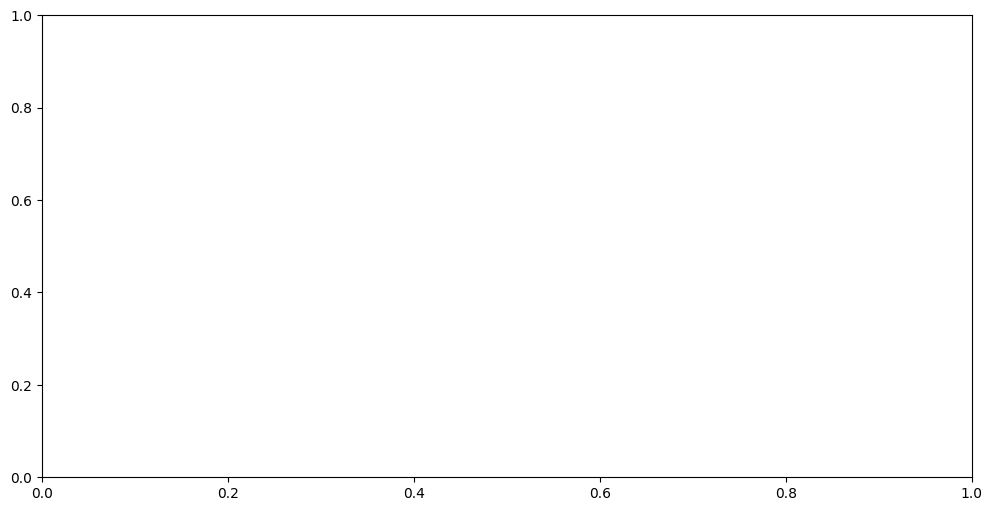

In [25]:
plot_losses(doge_train_losses,doge_validation_losses, doge_epoch)

In [ ]:
doge_accuracy, doge_f1, doge_precision, doge_recall = evaluate_model(dogeCNN, val_loader)
print(f"""
Accuracy: {doge_accuracy}
F1-score: {doge_f1}
Precision: {doge_precision}
Recall: {doge_recall}""")

## ResNet
### Overview
ResNet is short for Residual Networks. Which is a form of neural network architecture developed to address the issue of training very deep networks. Kaiming He et al. initially presented it in the paper "Deep Residual Learning for Image Recognition".

### The Problem of Deep Networks
As neural networks become deeper, they start facing the vanishing/exploding gradient problem, which makes them hard to train. Before ResNet, this problem was a significant barrier to building networks with a very large number of layers.

To address the difficulties of training DNNs, ResNet introduces a simple yet effective concept called "Residual Learning". Instead of trying to learn direct mappings from inputs to outputs, each residual block learns residual functions with reference to block inputs.

$ z^{[l+1]} = W^{[l+1]} a^{[l]} + b^{[l+1]} $
\
$ a^{[l+1]} = g(z^{[l+1]}) $
\
$ z^{[l+2]} = W^{[l+2]} a^{[l+1]} + b^{[l+2]} $
\
$ a^{[l+2]} = g(z^{[l+2]} + a^{[l]}) \text{ instead of } g(z^{[l+2]}) $

$a^{[l]}$ here is the input of the $z^{[l+1]}$ layer.

In [27]:
from torchvision import models

resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

resnet.fc = nn.Linear(resnet.fc.in_features, num_output_classes)
resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 38.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
# Freezing the conv layers of resnet
for param in resnet.parameters():
    param.requires_grad = False

for param in resnet.fc.parameters():
    param.requires_grad = True


In [29]:
resnet_train_losses, resnet_validation_losses, resnet_epoch = train_model_with_validation(resnet, train_loader, val_loader, epochs=15, model_name="ResNet50", device=device)


Training...:   7%|▋         | 1/15 [00:33<07:52, 33.75s/it]

Epoch [1/15], Train Loss: 2.4662, Train Accuracy: 34.71%, Validation Loss: 2.2403, Validation Accuracy: 74.08%


Training...:  13%|█▎        | 2/15 [01:07<07:17, 33.66s/it]

Epoch [2/15], Train Loss: 1.9678, Train Accuracy: 82.77%, Validation Loss: 1.7687, Validation Accuracy: 87.30%


Training...:  20%|██        | 3/15 [01:41<06:44, 33.69s/it]

Epoch [3/15], Train Loss: 1.5672, Train Accuracy: 87.68%, Validation Loss: 1.4032, Validation Accuracy: 92.55%


Training...:  27%|██▋       | 4/15 [02:14<06:09, 33.63s/it]

Epoch [4/15], Train Loss: 1.2557, Train Accuracy: 92.66%, Validation Loss: 1.1262, Validation Accuracy: 95.49%
Epoch [5/15], Train Loss: 1.0282, Train Accuracy: 94.06%, Validation Loss: 0.9252, Validation Accuracy: 96.43%


Training...:  40%|████      | 6/15 [03:21<05:01, 33.52s/it]

Epoch [6/15], Train Loss: 0.8371, Train Accuracy: 95.68%, Validation Loss: 0.7552, Validation Accuracy: 97.38%


Training...:  47%|████▋     | 7/15 [03:55<04:28, 33.52s/it]

Epoch [7/15], Train Loss: 0.7131, Train Accuracy: 96.53%, Validation Loss: 0.6442, Validation Accuracy: 97.69%


Training...:  53%|█████▎    | 8/15 [04:28<03:54, 33.52s/it]

Epoch [8/15], Train Loss: 0.6115, Train Accuracy: 97.12%, Validation Loss: 0.5588, Validation Accuracy: 98.01%


Training...:  60%|██████    | 9/15 [05:02<03:20, 33.49s/it]

Epoch [9/15], Train Loss: 0.5280, Train Accuracy: 97.64%, Validation Loss: 0.4946, Validation Accuracy: 98.22%
Epoch [10/15], Train Loss: 0.4507, Train Accuracy: 98.16%, Validation Loss: 0.4183, Validation Accuracy: 98.43%


Training...:  73%|███████▎  | 11/15 [06:09<02:14, 33.57s/it]

Epoch [11/15], Train Loss: 0.3985, Train Accuracy: 98.34%, Validation Loss: 0.3657, Validation Accuracy: 98.85%


Training...:  80%|████████  | 12/15 [06:43<01:40, 33.61s/it]

Epoch [12/15], Train Loss: 0.3620, Train Accuracy: 98.49%, Validation Loss: 0.3255, Validation Accuracy: 98.95%


Training...:  87%|████████▋ | 13/15 [07:16<01:07, 33.51s/it]

Epoch [13/15], Train Loss: 0.3288, Train Accuracy: 98.71%, Validation Loss: 0.3068, Validation Accuracy: 99.16%


Training...:  93%|█████████▎| 14/15 [07:49<00:33, 33.46s/it]

Epoch [14/15], Train Loss: 0.2969, Train Accuracy: 98.93%, Validation Loss: 0.2735, Validation Accuracy: 99.16%
Epoch [15/15], Train Loss: 0.2747, Train Accuracy: 98.89%, Validation Loss: 0.2504, Validation Accuracy: 99.16%


Training...: 100%|██████████| 15/15 [08:23<00:00, 33.54s/it]



Resnet50 model
Accuracy: 0.9916054564533053
F1-score: 0.9915898829541286
Precision: 0.9916565220928948
Recall: 0.9916054564533053


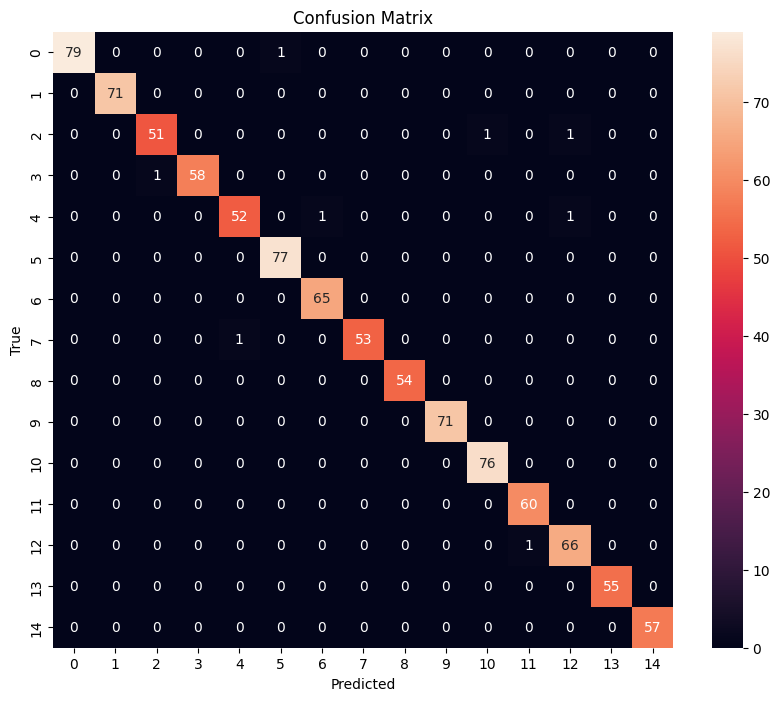

In [32]:
resnet_accuracy, resnet_f1, resnet_precision, resnet_recall = evaluate_model(resnet, val_loader)
print(f"""
Resnet50 model
Accuracy: {resnet_accuracy}
F1-score: {resnet_f1}
Precision: {resnet_precision}
Recall: {resnet_recall}""")

## Inception

![](https://i.kym-cdn.com/photos/images/newsfeed/000/531/557/a88.jpg)

### Overview
Google researchers developed the Inception model, often known as GoogLeNet, in 2014, which represented a significant improvement in deep learning for image identification. The term "Inception" is derived from a network architecture concept in the film "Inception," in which a dream is nested within another dream.

### Features

- **Inception Module:** The Inception's fundamental concept is the Inception module, which allows the network to choose between numerous convolutional operations (with varying filter sizes) and pooling processes in parallel inside the same module. This architecture allows the model to capture features at different scales.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/Screenshot-from-2018-10-17-11-14-10.png)

- **Depth and Width:** While increasing model depth and width, it also takes training and computing requirements into consideration
- **Auxiliary Classifiers:** Inception uses auxiliary classifiers during training to fight the vanishing gradient problem in deep networks. These classifiers are connected to intermediate layers and contribute to the network's total loss, assisting in gradient propagation.
- **Efficiency:** Despite its deps and complexity, the Inception model is computationally efficient due to its carefully designed architecture. Allowing the model to perform well even on edge devices with limited computing capabilities.


In [33]:
inception = models.inception_v3(pretrained='weights=Inception_V3_Weights.IMAGENET1K_V1')
inception.fc = nn.Linear(inception.fc.in_features, num_output_classes)
# editing the auxiliary output layer to our case
if inception.AuxLogits is not None:
    inception.AuxLogits.fc = nn.Linear(inception.AuxLogits.fc.in_features, num_output_classes)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 228MB/s]  


In [34]:
# freeze the model's trainable parameters 
for param in inception.parameters():
    param.requires_grad = False

# only train the final layer and the auxiliary layer
for param in inception.fc.parameters():
    param.requires_grad = True

if inception.AuxLogits is not None:
    for param in inception.AuxLogits.fc.parameters():
        param.requires_grad = True


In [35]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

def train_inception(model, train_loader, validation_loader, epochs, model_name, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    time.sleep(0.1)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    model = model.to(device)

    train_losses = []
    validation_losses = []

    with open(f"{model_name}_results.txt", "w") as f:
        for epoch in tqdm(range(epochs)):
            # Training
            model.train()
            epoch_train_losses = []
            total = 0
            correct = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                # Handle Inception model's auxiliary output in training
                if model_name == 'InceptionV3':
                    outputs, aux_outputs = model(inputs)
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4 * loss2
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()
                epoch_train_losses.append(loss.item())

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
            train_accuracy = 100 * correct / total
            train_losses.append(avg_train_loss)

            # Validation
            model.eval()
            epoch_validation_losses = []
            total = 0
            correct = 0
            with torch.no_grad():
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    epoch_validation_losses.append(loss.item())

                    # Calculate accuracy
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            avg_val_loss = sum(epoch_validation_losses) / len(epoch_validation_losses)
            val_accuracy = 100 * correct / total
            validation_losses.append(avg_val_loss)

            # Print & save results to file
            results = (f"Epoch [{epoch+1}/{epochs}], "
                       f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
                       f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
            print(results)
            f.write(results + "\n")

            # Save checkpoints every 5 epochs
            if (epoch + 1) % 5 == 0:
                save_checkpoint(model, optimizer, epoch, criterion, filename=f'{model_name}_checkpoint_{epoch+1}.tar')

    return train_losses, validation_losses


def plot_losses(train_losses, validation_losses):
    epochs_list = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(12, 6))
    plt.plot(epochs_list, train_losses, label='Training Loss')
    plt.plot(epochs_list, validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [36]:
inception_train_losses, inception_validation_losses = train_inception(inception, train_loader, val_loader, epochs=10, model_name="InceptionV3", device=device)


 10%|█         | 1/10 [00:29<04:29, 29.98s/it]

Epoch [1/10], Train Loss: 2.8138, Train Accuracy: 56.22%, Validation Loss: 1.3258, Validation Accuracy: 97.17%


 20%|██        | 2/10 [00:59<03:58, 29.82s/it]

Epoch [2/10], Train Loss: 1.1947, Train Accuracy: 94.43%, Validation Loss: 0.5533, Validation Accuracy: 98.95%


 30%|███       | 3/10 [01:29<03:28, 29.72s/it]

Epoch [3/10], Train Loss: 0.5731, Train Accuracy: 97.45%, Validation Loss: 0.2821, Validation Accuracy: 99.06%


 40%|████      | 4/10 [01:58<02:58, 29.71s/it]

Epoch [4/10], Train Loss: 0.3568, Train Accuracy: 98.23%, Validation Loss: 0.1852, Validation Accuracy: 99.16%
Epoch [5/10], Train Loss: 0.2710, Train Accuracy: 98.08%, Validation Loss: 0.1395, Validation Accuracy: 99.16%


 60%|██████    | 6/10 [02:58<01:58, 29.70s/it]

Epoch [6/10], Train Loss: 0.2259, Train Accuracy: 98.41%, Validation Loss: 0.1146, Validation Accuracy: 99.37%


 70%|███████   | 7/10 [03:27<01:28, 29.59s/it]

Epoch [7/10], Train Loss: 0.1979, Train Accuracy: 98.23%, Validation Loss: 0.0988, Validation Accuracy: 99.37%


 80%|████████  | 8/10 [03:57<00:59, 29.55s/it]

Epoch [8/10], Train Loss: 0.1720, Train Accuracy: 98.45%, Validation Loss: 0.0850, Validation Accuracy: 99.48%


 90%|█████████ | 9/10 [04:26<00:29, 29.51s/it]

Epoch [9/10], Train Loss: 0.1579, Train Accuracy: 98.56%, Validation Loss: 0.0748, Validation Accuracy: 99.58%
Epoch [10/10], Train Loss: 0.1496, Train Accuracy: 98.67%, Validation Loss: 0.0675, Validation Accuracy: 99.48%


100%|██████████| 10/10 [04:56<00:00, 29.65s/it]



Resnet50 model
Accuracy: 0.9947534102833159
F1-score: 0.9947615019710304
Precision: 0.994859302991517
Recall: 0.9947534102833159


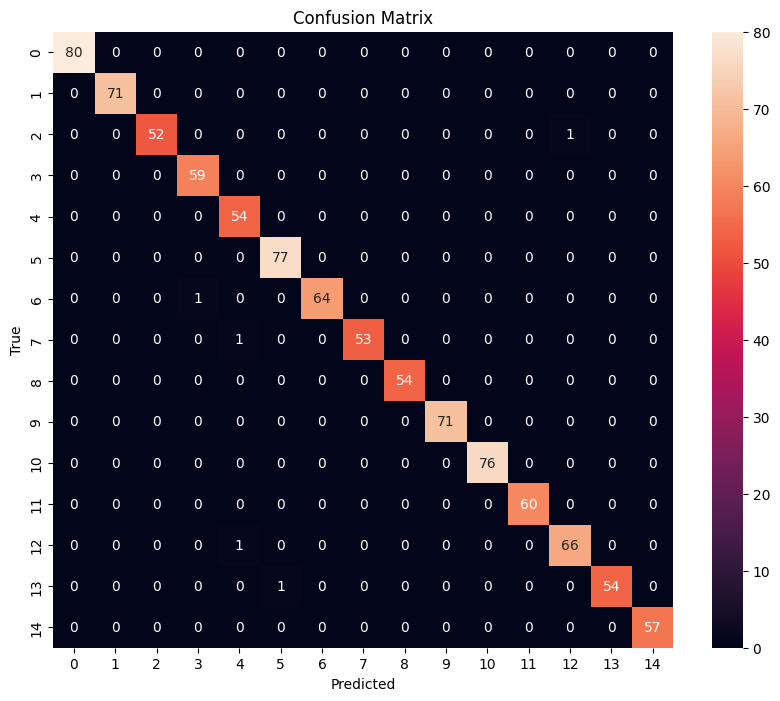

In [38]:
inception_accuracy, inception_f1, inception_precision, inception_recall = evaluate_model(inception, val_loader)
print(f"""
Resnet50 model
Accuracy: {inception_accuracy}
F1-score: {inception_f1}
Precision: {inception_precision}
Recall: {inception_recall}""")

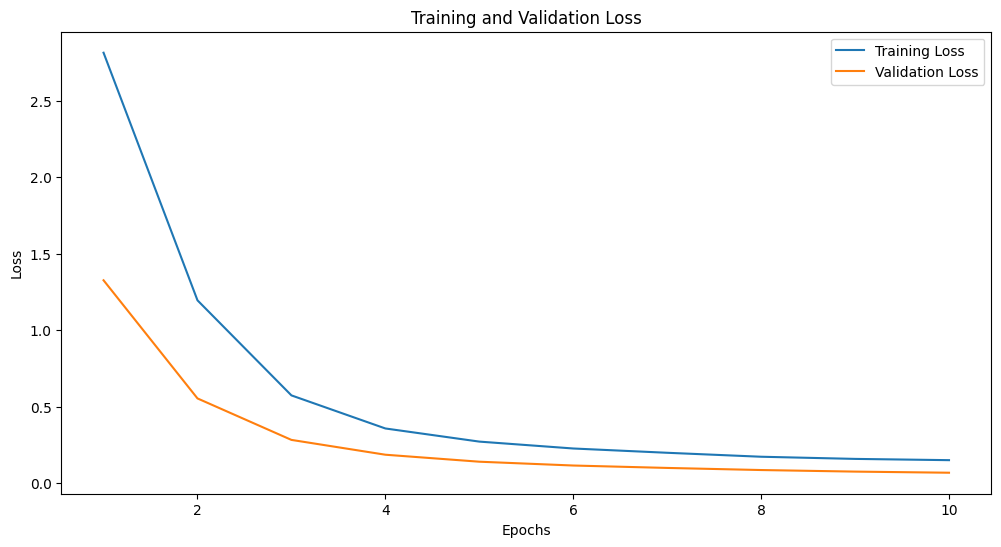

In [39]:
plot_losses(inception_train_losses, inception_validation_losses)


In [47]:
def read_model_results(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    for line in lines:
        parts = line.split(',')
        train_loss = float(parts[1].split(': ')[1])
        train_accuracy = float(parts[2].split(': ')[1].replace('%', ''))
        val_loss = float(parts[3].split(': ')[1])
        val_accuracy = float(parts[4].split(': ')[1].replace('%', ''))

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    return train_losses, val_losses, train_accuracies, val_accuracies



def plot_combined_results(model_results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Comparison')

    
    for i, (model_name, results) in enumerate(model_results.items()):
        axes[i//2, i%2].plot(results['train_losses'], label='Training Loss')
        axes[i//2, i%2].plot(results['val_losses'], label='Validation Loss')
        axes[i//2, i%2].set_title(f'{model_name} Loss')
        axes[i//2, i%2].set_xlabel('Epochs')
        axes[i//2, i%2].set_ylabel('Loss')
        axes[i//2, i%2].legend()

    
    plt.figure(figsize=(16, 12))
    for model_name, results in model_results.items():
        epochs = list(range(1, len(results['train_losses']) + 1))
        plt.subplot(2, 1, 1)
        plt.plot(epochs, results['train_losses'], label=f'{model_name} Training Loss')
        plt.plot(epochs, results['val_losses'], label=f'{model_name} Validation Loss', linestyle='dashed')
        plt.title('Training and Validation Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, results['train_accuracies'], label=f'{model_name} Training Accuracy')
        plt.plot(epochs, results['val_accuracies'], label=f'{model_name} Validation Accuracy', linestyle='dashed')
        plt.title('Training and Validation Accuracies')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()

    plt.tight_layout()
    plt.show()


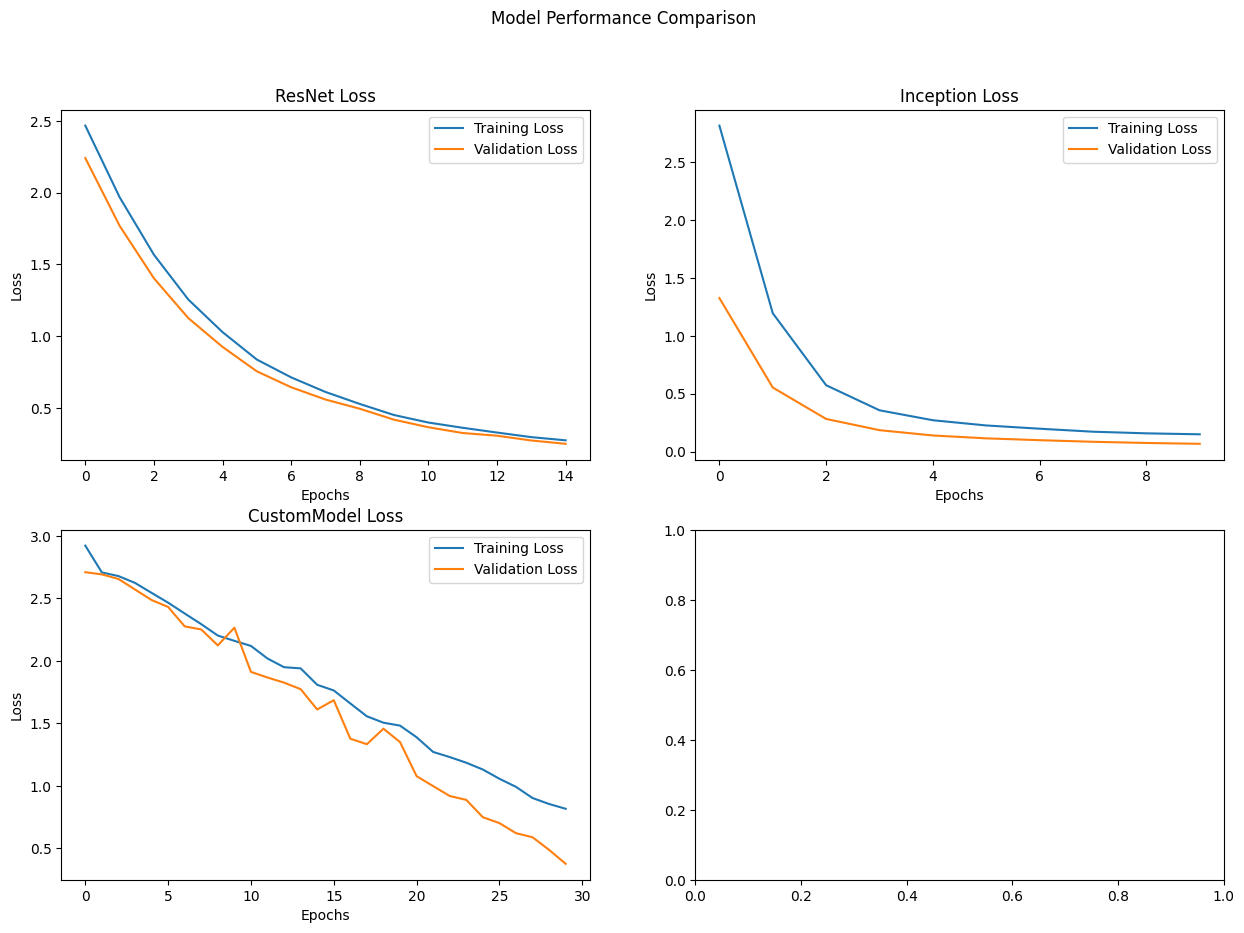

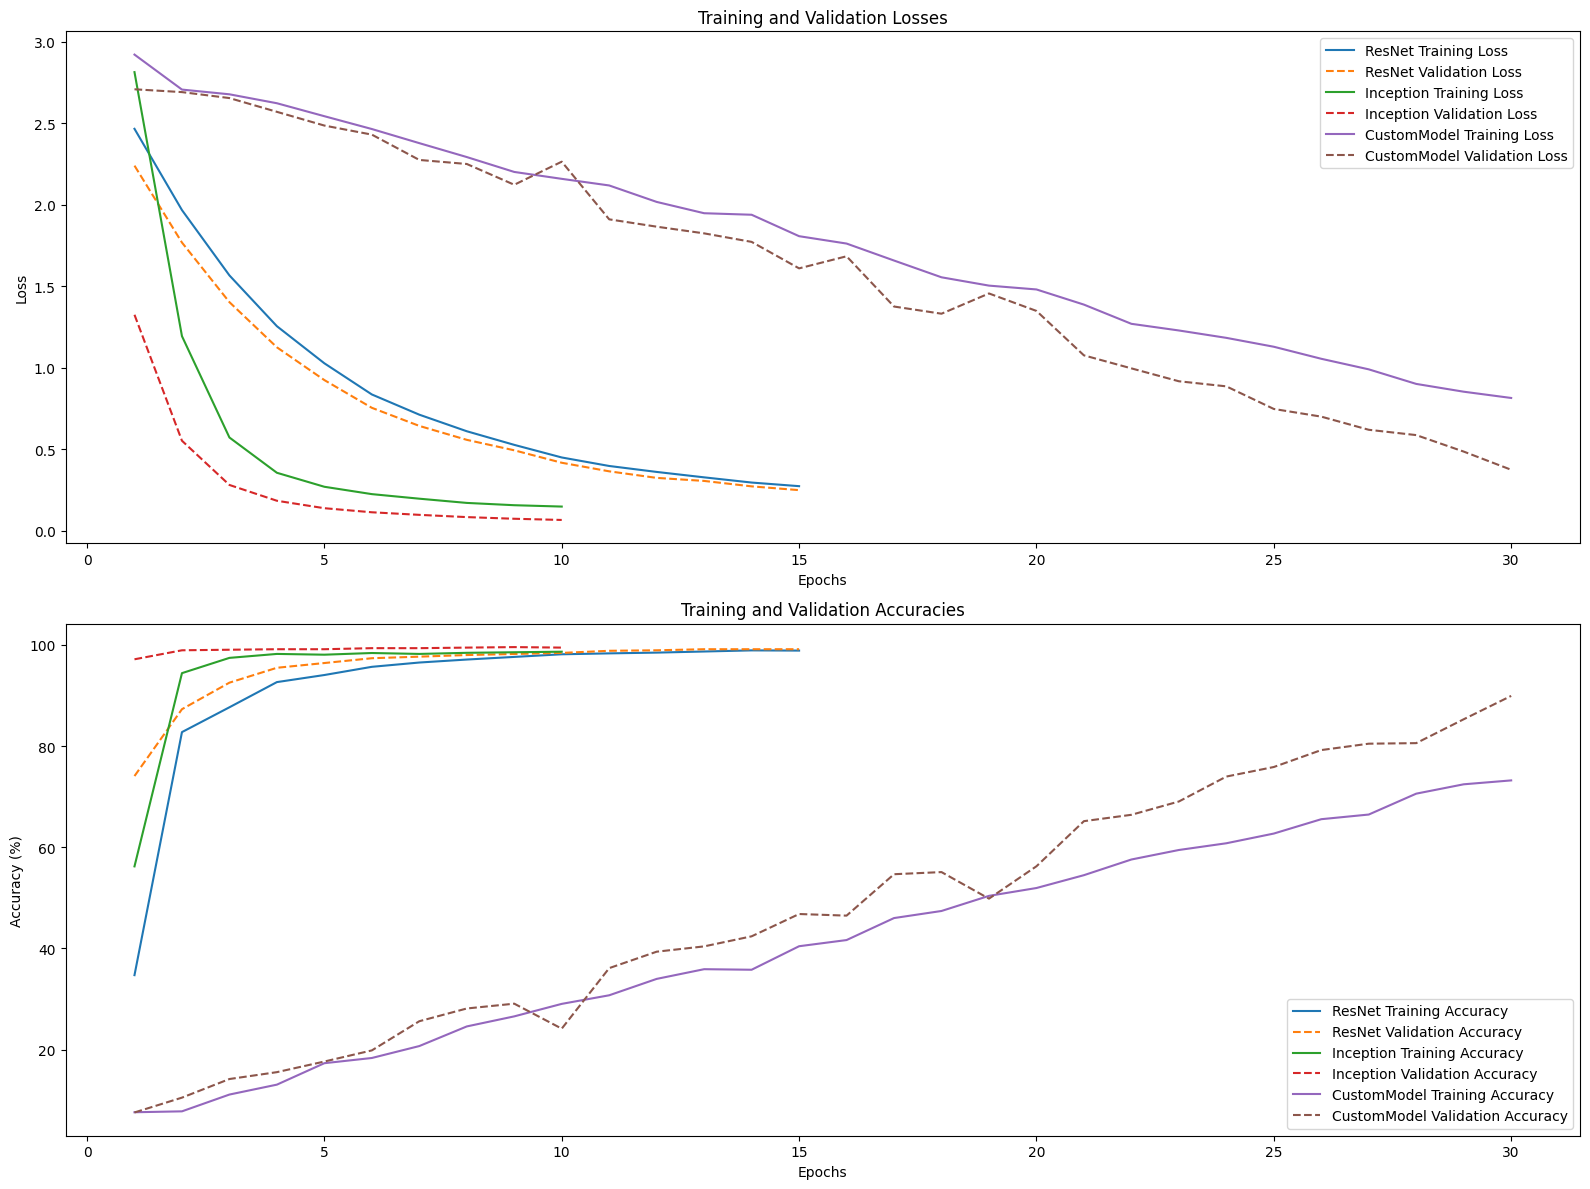

In [48]:
# Read the model results
resnet_results = read_model_results('/kaggle/working/ResNet50_results.txt')
inception_results = read_model_results('/kaggle/working/InceptionV3_results.txt')
dogeCNN_results = read_model_results('/kaggle/working/dogeCNN_results.txt')

# Combine the results
model_results = {
    'ResNet': {'train_losses': resnet_results[0], 'val_losses': resnet_results[1],
               'train_accuracies': resnet_results[2], 'val_accuracies': resnet_results[3]},
    'Inception': {'train_losses': inception_results[0], 'val_losses': inception_results[1],
                  'train_accuracies': inception_results[2], 'val_accuracies': inception_results[3]},
    'CustomModel': {'train_losses': custom_results[0], 'val_losses': custom_results[1],
                    'train_accuracies': custom_results[2], 'val_accuracies': custom_results[3]}
}

# Plot the combined results
plot_combined_results(model_results)


## Reference
- Deep Learning Specialization Course 4 by DeepLearning.AI
